In [1]:
%matplotlib inline
from pylab import * # imshow()
import numpy as np
from tqdm import trange # progress bar

In [2]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
X_train.reshape(-1, 28*28).shape


(60000, 784)

(<matplotlib.image.AxesImage at 0x7fbb14438400>, 5)

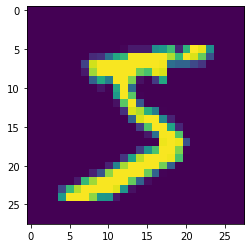

In [4]:
imshow(X_train[0]), Y_train[0]

In [5]:
# model
import torch
import torch.nn as nn

class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

In [6]:
# model(torch.tensor(X_train[0:10].reshape((-1, 28*28))).float())

loss 0.95 accuracy 0.97: 100%|█████████████| 1000/1000 [00:03<00:00, 308.08it/s]


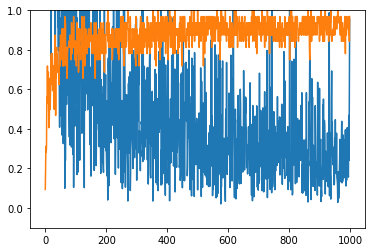

In [7]:
# training
model = BobNet()
BS = 32
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size = (BS))
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    optim.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    # print(loss)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1)
plot(losses)
plot(accuracies)

In [8]:
# evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9164